In [1]:
import pandas as pd
import geopandas
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import nuts
import settings
import plots
import eust

In [2]:
nuts_table = nuts.get_nuts_candidates()
EU28_countries = list(nuts_table.country_code.unique())

In [3]:
refareas = pd.read_csv(settings.REFERENCE_AREAS_PATH, index_col='geo')
refareas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.72689,2.28822
AT1,1.09884,1.08506
AT11,0.18197,0.17671
AT12,0.90885,0.90100
AT13,0.00802,0.00735
...,...,...
UKM3,0.79834,0.48694
UKM5,0.47877,0.31144
UKM6,2.76356,0.43391


In [4]:
harvest = pd.read_csv(settings.HARVEST_PATH, index_col='geo')
harvest

,UAA,UAA_XJ2000_J3000
geo,,
AT,34.822616,31.372186
AT1,15.792107,15.704185
AT11,2.432277,2.405337
AT12,13.916372,13.861194
AT13,0.097659,0.096332
...,...,...
UKM3,13.680010,8.397701
UKM5,8.409825,5.636565
UKM6,47.173386,7.513101


In [5]:
excretion = pd.read_csv(settings.EXCRETION_PATH, index_col='geo').excretion
excretion

geo
AT      27.834650
AT11     0.395425
AT12     6.347312
AT13     0.002201
AT21     2.369130
          ...    
UKM2    10.211552
UKM3    11.429717
UKM5     4.001366
UKM6     6.979625
UKN0    23.973491
Name: excretion, Length: 286, dtype: float64

In [6]:
mineral = pd.read_csv(settings.MINERAL_FERTILIZER_PATH, index_col='geo').mineral
mineral

geo
AT      17.261000
AT1      6.955574
AT11     1.341202
AT12     7.997492
AT13     0.050766
          ...    
UKM3     3.771635
UKM5     2.261876
UKM6    13.056016
UKN      2.735834
UKN0     2.735834
Name: mineral, Length: 427, dtype: float64

# Gather quantities for refarea alternatives

In [7]:
quantities_all = {
    k: pd.DataFrame(
        dict(
            harvest=harvest[k],
            excretion=excretion,
            mineral=mineral,
            refarea=refareas[k],
        )
    )
    .reindex(nuts_table.index)
    for k in refareas.columns
}
quantities_all

{'UAA':         harvest  excretion    mineral  refarea
 geo                                           
 AT    34.822616  27.834650  17.261000  2.72689
 AT1   15.792107        NaN   6.955574  1.09884
 AT11   2.432277   0.395425   1.341202  0.18197
 AT12  13.916372   6.347312   7.997492  0.90885
 AT13   0.097659   0.002201   0.050766  0.00802
 ...         ...        ...        ...      ...
 UKM3  13.680010  11.429717   3.771635  0.79834
 UKM5   8.409825   4.001366   2.261876  0.47877
 UKM6  47.173386   6.979625  13.056016  2.76356
 UKN   17.927024        NaN   2.735834  1.04614
 UKN0  17.927024  23.973491   2.735834  1.04614
 
 [390 rows x 4 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral  refarea
 geo                                           
 AT    31.372186  27.834650  17.261000  2.28822
 AT1   15.704185        NaN   6.955574  1.08506
 AT11   2.405337   0.395425   1.341202  0.17671
 AT12  13.861194   6.347312   7.997492  0.90100
 AT13   0.096332   0.002201   0.05

# Calculate rates (quantity / refarea)

In [8]:
rates_all = {
    k: v.div(v["refarea"], axis=0).drop(columns="refarea")
    for k, v in quantities_all.items()
}
rates_all

{'UAA':         harvest  excretion   mineral
 geo                                 
 AT    12.770085  10.207471  6.329922
 AT1   14.371617        NaN  6.329924
 AT11  13.366362   2.173025  7.370455
 AT12  15.312067   6.983894  8.799573
 AT13  12.176923   0.274447  6.329915
 ...         ...        ...       ...
 UKM3  17.135569  14.316853  4.724347
 UKM5  17.565480   8.357596  4.724347
 UKM6  17.069789   2.525592  4.724347
 UKN   17.136353        NaN  2.615170
 UKN0  17.136353  22.916140  2.615170
 
 [390 rows x 3 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral
 geo                                  
 AT    13.710301  12.164324   7.543418
 AT1   14.473102        NaN   6.410312
 AT11  13.611777   2.237708   7.589846
 AT12  15.384233   7.044742   8.876239
 AT13  13.106439   0.299465   6.906927
 ...         ...        ...        ...
 UKM3  17.245865  23.472536   7.745585
 UKM5  18.098399  12.847952   7.262637
 UKM6  17.314884  16.085422  30.089227
 UKN   17.187972       

# Calculate surplus per hectare

In [9]:
def calculate_surplus(quantities):
    return quantities.eval('(excretion + mineral - harvest) / refarea')

surplus_all = {
    k: v.pipe(calculate_surplus)
    for k, v in quantities_all.items()
}

# Compare country-level surplus calculated on different NUTS levels

If the data are consistent and have sufficiently high coverage, the results should agree rather closely but need not be exactly identical.

In [10]:
def country_sum_on_level(d, nuts_level):
    return (
        d
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(nuts_table.country_code)
        .groupby('country_code')
        .apply(lambda g: g.sum(skipna=False))
    )

def country_sum_on_levels(d, nuts_levels):
    return pd.concat(
        {
            nuts_level: country_sum_on_level(d, nuts_level)
            for nuts_level in nuts_levels
        },
        axis=1
    )

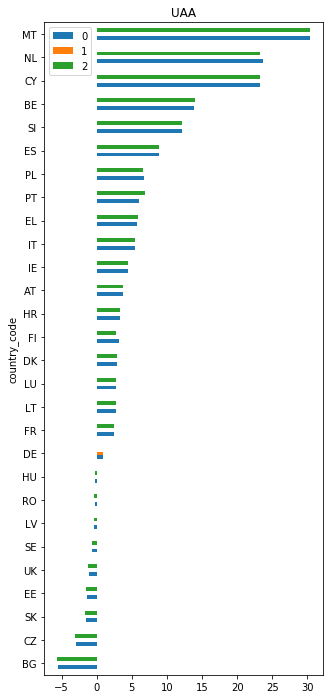

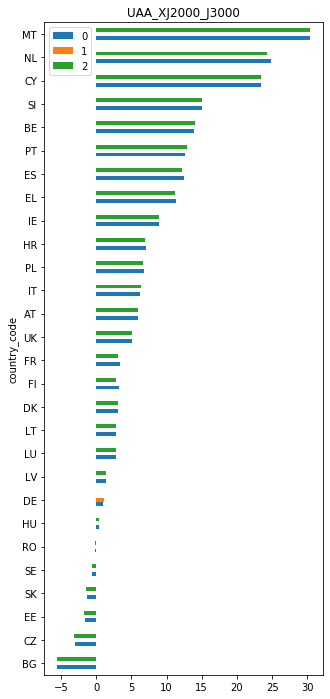

In [11]:
nuts_levels = [0, 1, 2]

for variant, q in quantities_all.items():
    ax = (
        country_sum_on_levels(q, nuts_levels)
        .stack(0)
        .pipe(calculate_surplus)
        .unstack()
        .sort_values(0)
        .plot
        .barh(figsize=(5, 12))
    )
    ax.set_title(variant)

# Select NUTS level to use for each country

In [12]:
selected_nuts_level = (
    pd.Series(
        {
            **{k: 2 for k in EU28_countries},
            **{'DE': 1}, # exceptions
        },
    )
    .rename_axis('country_code')
    .rename('nuts_level')
)

selected_regions = (
    nuts_table
    .reset_index()
    .merge(selected_nuts_level.reset_index(), on=['country_code', 'nuts_level'], how='inner')
    .set_index('geo')
    .index
)
selected_regions

def get_selected_subset(d, level=None):
    return d.reindex(selected_regions, level=level)

In [13]:
selected_regions

Index(['AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34',
       'BE10',
       ...
       'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM2', 'UKM3', 'UKM5', 'UKM6',
       'UKN0'],
      dtype='object', name='geo', length=243)

In [14]:
quantities = {
    k: v.pipe(get_selected_subset)
    for k, v in quantities_all.items()
}

rates = {
    k: v.pipe(get_selected_subset)
    for k, v in rates_all.items()
}

surplus = {
    k: v.pipe(get_selected_subset)
    for k, v in surplus_all.items()
}

# Prepare for plotting

In [15]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID').loc[selected_regions]

def plot_variable_choropleth(s, ax=None, **kwargs):
    key = s.name
    
    d = nuts_geo[['geometry']].join(s, how='inner')
    
    kwargs_final = {
        'legend_kws': {
            'loc': 'upper left',
            'bbox_to_anchor': (1.05, 1.1),
            'borderaxespad': 0,
            'frameon': False,
            'title': 'kg P / ha',
        },
        **plots.CHOROPLETH_KWS[key],
        **kwargs,
    }
    
    ax = plots.plot_europe_choropleth(d, key, ax=ax, **kwargs_final)
    return ax

In [16]:
# Figure sizes etc
COLWIDTH = 76 / 25.4
TEXTWIDTH = 160 / 25.4

sns.set_style('darkgrid')
sns.set(
    font="Arial",
    rc={
        "xtick.labelsize": 8.5,
        "ytick.labelsize": 8.5,
        "axes.titlesize": 9,
        "axes.labelsize": 8.5,
        "legend.title_fontsize": 8.5,
        "legend.fontsize": 8.5,
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "mathtext.rm": "Arial",
        "mathtext.fontset": "custom",
        "axes.facecolor": "#eaeaea",
    },
)


def adjust_print_plot(fig, **kwargs):
    defaults = dict(left=0, bottom=0, right=1, top=0.97, wspace=0.05, hspace=0.05)
    
    fig.subplots_adjust(**{**defaults, **kwargs})

# Plot surplus terms

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


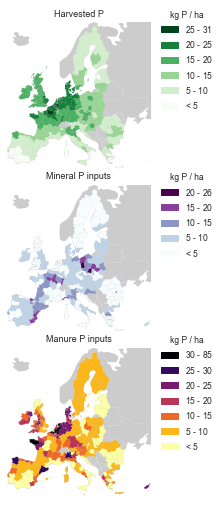

In [17]:
fig, axs = plt.subplots(nrows=3, figsize=(COLWIDTH, COLWIDTH * 2.3))

subplots = [
    dict(
        title='Harvested P',
        variable='harvest',
    ),
    dict(
        title='Mineral P inputs',
        variable='mineral',  
    ),
    dict(
        title='Manure P inputs',
        variable='excretion',
    )
]

for ax, sp in zip(axs, subplots):
    variable = sp['variable']
    plot_variable_choropleth(        
        rates['UAA'][variable].rename(variable),
        ax=ax,
    )
    ax.set_title(sp['title'])
    
adjust_print_plot(fig, right=0.7)
fig.savefig('outdata/figures/Fig2.pdf')

# Plot surplus with both reference areas

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


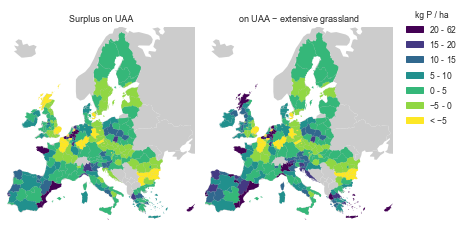

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(TEXTWIDTH, COLWIDTH * 1.1))

subplots = [
    dict(
        title='Surplus on UAA',
        variant='UAA',
        legend=False,
    ),
    dict(
        title='on UAA $-$ extensive grassland',
        variant='UAA_XJ2000_J3000',
        legend=True,        
    )    
]

for ax, sp in zip(axs, subplots):
    plot_variable_choropleth(
        surplus[sp['variant']].rename('surplus'),
        legend=sp['legend'],
        ax=ax,
    )
    ax.set_title(sp['title'])
    
adjust_print_plot(fig, right=0.85)
fig.savefig('outdata/figures/Fig3.pdf')

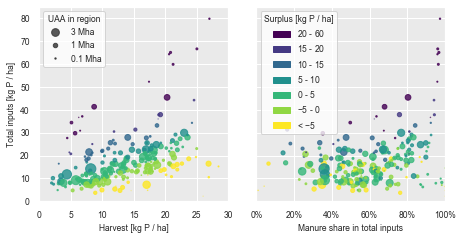

In [19]:
import mapclassify

surplus_scheme = mapclassify.UserDefined(
    surplus['UAA'],
    plots.CHOROPLETH_KWS['surplus']['bin_uls'],
)
surplus_cmap = plots.CHOROPLETH_KWS['surplus']['cmap']
surplus_fmt = plots.CHOROPLETH_KWS['surplus']['legend_fmt']

binned_surplus = pd.Series(data=surplus_scheme.yb, index=surplus['UAA'].index).rename('binned_surplus')
marker = 'o'
area_scale = 20
alpha = 0.8

scatter_data = (
    rates['UAA']
    .join(binned_surplus)
    .join(refareas['UAA'].rename('UAA').mul(area_scale))
    .assign(
        input_sum=lambda d: d.mineral + d.excretion,
        frac_manure=lambda d: d.excretion / d.input_sum
    )
)
scatter_data = scatter_data.sample(len(scatter_data), replace=False) # shuffle randomly

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(TEXTWIDTH, COLWIDTH * 1.1))

harvest_ax, frac_ax = axs

axs[0].set_ylabel('Total inputs [kg P / ha]')


harvest_ax.scatter(
    x='harvest',
    y='input_sum',
    c='binned_surplus',
    s='UAA',
    cmap=surplus_cmap,
    data=scatter_data,
    marker=marker,
    alpha=alpha,
)

harvest_ax.set_xlabel('Harvest [kg P / ha]')
harvest_ax.set_xlim(0, 30)

for ax in axs:
    ax.set_ylim(0, 85)


frac_ax.scatter(
    x='frac_manure',
    y='input_sum',
    c='binned_surplus',
    s='UAA',
    cmap=surplus_cmap,
    data=scatter_data,
    marker=marker,
    alpha=alpha,
)

frac_ax.set_xlabel('Manure share in total inputs')
frac_ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
frac_ax.set_xlim(0, 1)

frac_ax.legend(
    handles=plots.make_legend_handles(surplus_scheme, surplus_cmap, fmt=surplus_fmt),
    title='Surplus [kg P / ha]',
    facecolor='#ffffff',
    framealpha=0.8,
    bbox_to_anchor=(0, 1),
    loc='upper left',
)

reference_areas = [0.1, 1, 3]
size_patches = [
    mpl.lines.Line2D(
        markersize=(area * area_scale)**0.5,
        lw=0,
        marker=marker,
        xdata=[],
        ydata=[],
        color='#303030',
        alpha=alpha,
        label=f'{area:,g} Mha',
    )
    for area in reference_areas
]

harvest_ax.legend(
    handles=size_patches[::-1],
    facecolor='#ffffff',
    framealpha=0.8,
    bbox_to_anchor=(0, 1),
    loc='upper left',
    title="UAA in region",
)


adjust_print_plot(fig, left=0.08, right=0.975, bottom=0.15, wspace=0.15)

fig.savefig('outdata/figures/Fig4.pdf')

In [20]:
eurostat_surplus = (
    eust.read_table_data('aei_pr_gnb', version='2019-05-22 23:00:00')
    .value
    .xs('P', level='nutrient')
    .xs(settings.DATA_YEAR, level='time')
    .unstack('indic_ag')
    .eval('BAL / UAA')
    .rename('Eurostat')
)

In [21]:
# From Fig. 4 in van Dijk et al. (2016) Sci. Tot. Env. 542 pp. 1078-1093
vanDijk_surplus = (
    pd.Series(
        {
            'BE': 23.2,
            'NL': 21.9,
            'PT': 13.2,
            'DK': 10.1,
            'ES': 9.0,
            'IT': 7.5,
            'PL': 7.4,
            'FI': 7.4,
            'IE': 6.7,
            'LU': 6.1,
            'EL': 5.9,
            'UK': 4.2,
            'FR': 3.8,
            'DE': 1.8,
            'LT': 0.8,
            'SE': 0.5,
            'BG': -0.1,
            'AT': -0.1,
            'SI': -0.4,
            'LV': -0.9,
            'HU': -1.0,
            'EE': -1.1,
            'CZ': -2.1,
            'SK': -2.8,
        }
    )
    .rename('van Dijk et al.')
    .rename_axis('geo')
)

In [22]:
national_data = (
    eurostat_surplus.to_frame()
    .join(surplus_all['UAA'].rename('This study'), how='inner')
    .join(vanDijk_surplus)
    .sort_values('This study', ascending=True)
    [['This study', 'Eurostat', 'van Dijk et al.']]
    .rename_axis('source', axis=1)
    .stack()
    .rename('surplus')
    .reset_index()
    .join(eust.read_country_names(), on='geo')
    .replace({'country': {'United Kingdom': 'UK', 'Czech Republic': 'Czech Rep.'}})
)

national_data

,geo,source,surplus,country
0,BG,This study,-5.564341,Bulgaria
1,BG,Eurostat,-8.503303,Bulgaria
2,BG,van Dijk et al.,-0.100000,Bulgaria
3,CZ,This study,-2.960767,Czech Rep.
4,CZ,Eurostat,-2.661744,Czech Rep.
...,...,...,...,...
75,NL,This study,23.723230,Netherlands
76,NL,Eurostat,4.585498,Netherlands
77,NL,van Dijk et al.,21.900000,Netherlands
78,MT,This study,30.416226,Malta


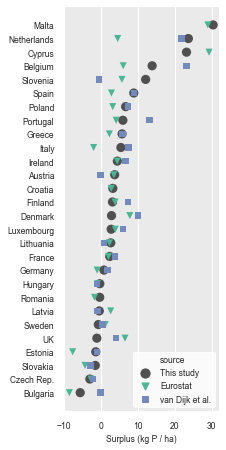

In [23]:
fig, ax = plt.subplots(figsize=(COLWIDTH, COLWIDTH * 2))
sns.scatterplot(
    x='surplus',
    y='country',
    hue='source',
    style='source',
    size='source',
    data=national_data,
    ax=ax,
    palette={
        'This study': '#505050',
        'Eurostat': sns.set_hls_values('#66c2a5', l=0.50),
        'van Dijk et al.': sns.set_hls_values('#8da0cb', l=0.60),
    },
    sizes={
        'This study': 85,
        'Eurostat': 50,
        'van Dijk et al.': 40,
    },
    markers={
        'This study': 'o',
        'Eurostat': 'v',
        'van Dijk et al.': 's',
    },
    linewidth=0,
    
)
ax.set_ylabel(None)
ax.set_xlabel('Surplus (kg P / ha)')
ax.grid(True, axis='x')
ax.grid(False, axis='y')
adjust_print_plot(fig, left=0.27, bottom=0.05, right=0.99, top=0.99)
ax.set_xlim(-10, 32)
legend = ax.get_legend()
legend.set_title(None)
legend.get_frame().set_color('#ffffff')
legend.get_frame().set_alpha(0.8)
fig.savefig('outdata/figures/Fig5.pdf')